# Contents
#### 1. Imports
#### 2. Load data
#### 3. Use Checklist to perturb data
- 3.1 Change names
- 3.2 Change location
- 3.3 Change numbers
#### 4. Train LSTM
#### 5. Load fine-tuned DistilBERT
#### 6. Evaluate

## Imports

In [11]:
import torch
import spacy
from checklist.perturb import Perturb
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from datasets import Dataset
import os.path
import sklearn

## Load data

In [12]:
def read_iob2_file(path):
    """
    read in conll file
    
    :param path: path to read from
    :returns: list with sequences of words and labels for each sentence
    """
    data = []
    current_words = []
    current_tags = []

    for line in open(path, encoding='utf-8'):
        line = line.strip()
        if line:
            if line[0] == '#':
                continue # skip comments
            tok = line.split('\t')

            current_words.append(tok[1])
            current_tags.append(tok[2])
        else:
            if current_words:  # skip empty lines
                data.append((current_words, current_tags))
            current_words = []
            current_tags = []

    # check for last one
    if current_tags != []:
        data.append((current_words, current_tags))
    return data

train_data= read_iob2_file('data//en_ewt-ud-train.iob2')
dev_data = read_iob2_file('data//en_ewt-ud-dev.iob2')

In [3]:
# Hyperparameters
DIM_EMBEDDING = 100
LSTM_HIDDEN = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 7
PAD = '<PAD>'

In [4]:
class Vocab():
    def __init__(self, pad_unk):
        """
        A convenience class that can help store a vocabulary
        and retrieve indices for inputs.
        """
        self.pad_unk = pad_unk
        self.word2idx = {self.pad_unk: 0}
        self.idx2word = [self.pad_unk]

    def getIdx(self, word, add=False):
        if word not in self.word2idx:
            if add:
                self.word2idx[word] = len(self.idx2word)
                self.idx2word.append(word)
            else:
                return self.word2idx[self.pad_unk]
        return self.word2idx[word]

    def getWord(self, idx):
        return self.idx2word[idx]


max_len = max([len(x[0]) for x in train_data ])

# Create vocabularies for both the tokens
# and the tags
token_vocab = Vocab(PAD)
label_vocab = Vocab(PAD)
id_to_token = [PAD]

for tokens, tags in train_data:
    for token in tokens:
        token_vocab.getIdx(token, True)
    for tag in tags:
        label_vocab.getIdx(tag, True)

NWORDS = len(token_vocab.idx2word)
NTAGS = len(label_vocab.idx2word)

# convert text data with labels to indices
def data2feats(inputData, word_vocab, label_vocab):
    feats = torch.zeros((len(inputData), max_len), dtype=torch.long)
    labels = torch.zeros((len(inputData), max_len), dtype=torch.long)
    for sentPos, sent in enumerate(inputData):
        for wordPos, word in enumerate(sent[0][:max_len]):
            wordIdx = word_vocab.getIdx(word)
            feats[sentPos][wordPos] = wordIdx
        for labelPos, label in enumerate(sent[1][:max_len]):
            labelIdx = label_vocab.getIdx(label)
            labels[sentPos][labelPos] = labelIdx
    return feats, labels

train_features, train_labels = data2feats(train_data, token_vocab, label_vocab)
dev_feats, dev_labels = data2feats(dev_data, token_vocab, label_vocab)

## Use Checklist to perturb data

In [5]:
nlp = spacy.load("en_core_web_sm")
dataset = []
for sentence in dev_data:
    dataset.append(" ".join(sentence[0]))
pdataset = list(nlp.pipe(dataset))

### Change names

In [7]:
new_names_sents = []
new_names_data = []
# nsamples = how many 'name' sentences we want to take into account
# n = represents number of sentences that we want to generate for each 'name' sentence
t_names = Perturb.perturb(pdataset, Perturb.change_names, n=2)
original_sentences = []
for sentences in t_names.data:
    original_sentences.append(sentences[0])
# Tokenize
for sentences in t_names.data:
    for sentence in sentences:
        new_names_sents.append(sentence.split())
# Assign NER tags to the generated data
for index, new_sentence in enumerate(new_names_sents):
    for sentence in dev_data:
        if new_sentence == sentence[0]:
            ner_tag = sentence[1]
    if index % 3 != 0:
        new_names_data.append((new_names_sents[index],ner_tag))

changed_names_feats, dev_names_labels = data2feats(new_names_data, token_vocab, label_vocab)
print(len(new_names_data))
print(len(new_names_sents))
# Create gold labels file: index<TAB>word<TAB>label. 
# with open(os.path.join('data', 'gold_names.iob2'), 'w') as f:
#     for sentence, tag in new_names_data:
#         for index, (token, pred) in enumerate(zip(sentence, tag)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")

302
453


### Change locations

In [8]:
new_loc_sents = []
new_location_data = []
# nsamples = how many 'location' sentences we want to take into account
# n = represents number of sentences that we want to generate for each 'name' sentence
t_location = Perturb.perturb(pdataset, Perturb.change_location, n=2)
original_sentences = []
for sentences in t_location.data:
    original_sentences.append(sentences[0])
# Tokenize
for sentences in t_location.data:
    for sentence in sentences:
        new_loc_sents.append(sentence.split())
# Assign NER tags to the generated data
for index, new_sentence in enumerate(new_loc_sents):
    for sentence in dev_data:
        if new_sentence == sentence[0]:
            ner_tag = sentence[1]
    if index % 3 != 0:
        new_location_data.append((new_loc_sents[index],ner_tag))

changed_location_feats, dev_location_labels = data2feats(new_location_data, token_vocab, label_vocab)

print(len(new_location_data))
print(len(new_loc_sents))
# Create gold labels file: index<TAB>word<TAB>label. 
# with open(os.path.join('data', 'gold_location.iob2'), 'w') as f:
#     for sentence, tag in new_location_data:
#         for index, (token, pred) in enumerate(zip(sentence, tag)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")

196
294


### Change numbers

In [18]:
new_number_sents = []
new_number_data = []
# nsamples = how many 'number' sentences we want to take into account
# n = represents number of sentences that we want to generate for each 'name' sentence
t_number = Perturb.perturb(pdataset, Perturb.change_number, n=2)
original_sentences = []
for sentences in t_number.data:
    original_sentences.append(sentences[0])
# Tokenize
for sentences in t_number.data:
    for sentence in sentences:
        new_number_sents.append(sentence.split())
# Assign NER tags to the generated data
for index, new_sentence in enumerate(new_number_sents):
    for sentence in dev_data:
        if new_sentence == sentence[0]:
            ner_tag = sentence[1]
    if index % 3 != 0:
        new_number_data.append((new_number_sents[index],ner_tag))

changed_number_feats, dev_numbers_labels = data2feats(new_number_data, token_vocab, label_vocab)

print(len(new_number_data))
print(len(new_number_sents))
# Create gold labels file: index<TAB>word<TAB>label. 
# with open(os.path.join('data', 'gold_numbers.iob2'), 'w') as f:
#     for sentence, tag in new_number_data:
#         for index, (token, pred) in enumerate(zip(sentence, tag)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")

279
419


## LSTM

In [15]:
class LangID(nn.Module):
    def __init__(self, embed_dim, lstm_dim, vocab_dim):
        super(LangID, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_dim, embed_dim)
        self.bilstm = nn.LSTM(embed_dim, lstm_dim, bidirectional=False, batch_first=True)
        self.hidden_to_tag = nn.Linear(lstm_dim, NTAGS)
        self.lstm_dim = lstm_dim
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, inputs):
        word_vectors = self.word_embeddings(inputs)
        bilstm_out, _ = self.bilstm(word_vectors)
        y = self.hidden_to_tag(bilstm_out)
        return y # softmax this in order to get probs, check out for axis, has to sum up to 1
    
    def predict(self, inputs):
        with torch.no_grad():
            data_feats, data_labels = data2feats(inputs, token_vocab, label_vocab)

            logits = self.forward(data_feats)
            probabilities = self.softmax(logits)
            return torch.argmax(probabilities, 2)


# define the model
langid_model = LangID(DIM_EMBEDDING, LSTM_HIDDEN, NWORDS)
loss_function = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = optim.Adam(langid_model.parameters(), lr=LEARNING_RATE)
print('model overview: ')
print(langid_model)
print()

model overview: 
LangID(
  (word_embeddings): Embedding(19674, 100)
  (bilstm): LSTM(100, 50, batch_first=True)
  (hidden_to_tag): Linear(in_features=50, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)



In [16]:
# convert to batches
num_batches = int(len(train_features)/BATCH_SIZE)
train_feats_batches = train_features[:BATCH_SIZE*num_batches].view(num_batches, BATCH_SIZE, max_len)
train_labels_batches = train_labels[:BATCH_SIZE*num_batches].view(num_batches, BATCH_SIZE, max_len)

In [17]:
print('epoch   loss      Train acc.')
for epoch in range(EPOCHS):
    langid_model.train() 
    langid_model.zero_grad()

    # Loop over batches
    loss = 0
    match = 0
    total = 0
    for batchIdx in range(0, num_batches):
        output_scores = langid_model.forward(train_feats_batches[batchIdx])
        
        output_scores = output_scores.view(BATCH_SIZE * max_len, -1)
        flat_labels = train_labels_batches[batchIdx].view(BATCH_SIZE * max_len)
        batch_loss = loss_function(output_scores, flat_labels)

        predicted_labels = torch.argmax(output_scores, 1)
        predicted_labels = predicted_labels.view(BATCH_SIZE, max_len)

        # Run backward pass
        batch_loss.backward()
        optimizer.step()
        langid_model.zero_grad()
        loss += batch_loss.item()
        # Update the number of correct tags and total tags
        for gold_sent, pred_sent in zip(train_labels_batches[batchIdx], predicted_labels):
            for gold_label, pred_label in zip(gold_sent, pred_sent):
                if gold_label != 0:
                    total += 1
                    if gold_label == pred_label:
                        match+= 1
    print('{0: <8}{1: <10}{2}'.format(epoch, '{:.2f}'.format(loss/num_batches), '{:.4f}'.format(match / total)))

epoch   loss      Train acc.
0       265.77    0.9473
1       112.65    0.9677
2       59.15     0.9827
3       35.15     0.9903
4       23.32     0.9938
5       16.21     0.9954
6       12.05     0.9965


## DistilBERT

In [11]:
# Load our finetuned model
fine_tuned = AutoModelForTokenClassification.from_pretrained("full_distilBERT/checkpoint-1568/")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
def get_sentences(path):
    """
    get sentences from conll file
    
    :param path: path to read from
    :returns: list with tokenized sentences
    """
    data = []

    for line in open(path, encoding='utf-8'):
        line = line.strip()
        if line:
            if line[:6] == '# text':
                data.append(line[9:])
    return data

dev_sentences = get_sentences('data//en_ewt-ud-dev.iob2')
dev_sents_tokenized = []
for sentence in dev_data:
    dev_sents_tokenized.append(sentence[0])

In [13]:
predictionTags = []

def run_eval_bert(sentences, gold_labels):
    match = 0
    total = 0
    for sents, labels in zip(sentences, gold_labels):
        inputs = tokenizer(sents, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
        predictionTagOneSentence = []
        with torch.no_grad():
            word_ids = inputs.word_ids()
            # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].flatten())
            logits = fine_tuned(**inputs).logits
            predictions = torch.argmax(logits, dim=-1).flatten()
            previous_word_idx = None
            for idx, word_idx in enumerate(word_ids):
                if previous_word_idx != word_idx and word_idx is not None:
                    predictionTagOneSentence.append(label_vocab.idx2word[predictions[idx].item()])
                previous_word_idx = word_idx
        predictionTags.append(predictionTagOneSentence)

        # Loop through gold labels
        for goldLabel, predLabel in zip(labels, predictions):
            if goldLabel.item() != 0:
                total += 1
                if goldLabel.item() == predLabel.item():
                    match+= 1
    return(match/total)

In [19]:
predictionsTags = []
sentences = []

def run_eval_lstm(feats_batches, labels_batches):
    langid_model.eval()
    match = 0
    total = 0
    for sents, labels in zip(feats_batches, labels_batches):
        output_scores = langid_model.forward(sents)
        predicted_tags  = torch.argmax(output_scores, 2)
        for sentence in sents:
            sentenceWords = []
            for wordIndex in sentence:
                sentenceWords.append(token_vocab.getWord(wordIndex.item()))
            sentences.append(sentenceWords)
        for sentenceTags in predicted_tags:
                predictionTagOneSentence = []
                for tag in sentenceTags:
                    predictionTagOneSentence.append(label_vocab.idx2word[tag.item()])
                predictionsTags.append(predictionTagOneSentence)
        for goldSent, predSent in zip(labels, predicted_tags):
            for goldLabel, predLabel in zip(goldSent, predSent):
                if goldLabel.item() != 0:
                    total += 1
                    if goldLabel.item() == predLabel.item():
                        match+= 1
    return(match/total)

## Evaluate

### LSTM

##### Dev data

In [22]:
sentences = []
predictionsTags = []

num_batches_dev = int(len(dev_feats)/BATCH_SIZE)

dev_feats_batches = dev_feats[:BATCH_SIZE*num_batches_dev].view(num_batches_dev, BATCH_SIZE, max_len)
dev_labels_batches = dev_labels[:BATCH_SIZE*num_batches_dev].view(num_batches_dev, BATCH_SIZE, max_len)
score = run_eval_lstm(dev_feats_batches, dev_labels_batches)

print('Accuracy for dev data: {:.4f}'.format(score))

# with open(os.path.join('data', 'lstm_predictions_dev.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(sentences, predictionsTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")

# python3 span_f1.py data/lstm_predictions_dev.iob2 data/en_ewt-ud-dev.iob2  <- run this in terminal to get span f1 score

Accuracy for dev data: 0.9478


##### Change names

In [16]:
sentences = []
predictionsTags = []

num_batches_changed_names = int(len(changed_names_feats)/BATCH_SIZE)

changed_names_feats_batches = changed_names_feats[:BATCH_SIZE*num_batches_changed_names].view(num_batches_changed_names, BATCH_SIZE, max_len)
changed_names_labels_batches = dev_names_labels[:BATCH_SIZE*num_batches_changed_names].view(num_batches_changed_names, BATCH_SIZE, max_len)
score = run_eval_lstm(changed_names_feats_batches, changed_names_labels_batches)

print('\033[32mAccuracy for changed names data: \033[0m {:.4f}'.format(score))

# with open(os.path.join('data', 'lstm_predictions_names.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(sentences, predictionsTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")
        
# python3 span_f1.py data/lstm_predictions_names.iob2 data/gold_names.iob2  <- run this in terminal to get span f1 score

Accuracy for changed names data:  0.8804


##### Change location

In [17]:
sentences = []
predictionsTags = []

num_batches_changed_location = int(len(changed_location_feats)/BATCH_SIZE)

changed_location_feats_batches = changed_location_feats[:BATCH_SIZE*num_batches_changed_location].view(num_batches_changed_location, BATCH_SIZE, max_len)
changed_location_labels_batches = dev_location_labels[:BATCH_SIZE*num_batches_changed_location].view(num_batches_changed_location, BATCH_SIZE, max_len)
score = run_eval_lstm(changed_location_feats_batches, changed_location_labels_batches)

print('\033[32mAccuracy for changed location data: \033[0m {:.4f}'.format(score))

# with open(os.path.join('data', 'lstm_predictions_location.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(sentences, predictionsTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")
        
# python3 span_f1.py data/lstm_predictions_location.iob2 data/gold_location.iob2  <- run this in terminal to get span f1 score

Accuracy for changed location data:  0.9143


##### Change numbers

In [27]:
sentences = []
predictionsTags = []

num_batches_changed_number = int(len(changed_number_feats)/BATCH_SIZE)

changed_number_feats_batches = changed_number_feats[:BATCH_SIZE*num_batches_changed_number].view(num_batches_changed_number, BATCH_SIZE, max_len)
changed_number_labels_batches = dev_numbers_labels[:BATCH_SIZE*num_batches_changed_number].view(num_batches_changed_number, BATCH_SIZE, max_len)
score = run_eval_lstm(changed_number_feats_batches, changed_number_labels_batches)

print('\033[32mAccuracy for changed number data: \033[0m {:.4f}'.format(score))

# with open(os.path.join('data', 'lstm_predictions_numbers.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(sentences, predictionsTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")
        
# python3 span_f1.py data/lstm_predictions_numbers.iob2 data/gold_numbers.iob2  <- run this in terminal to get span f1 score

Accuracy for changed number data:  0.9204


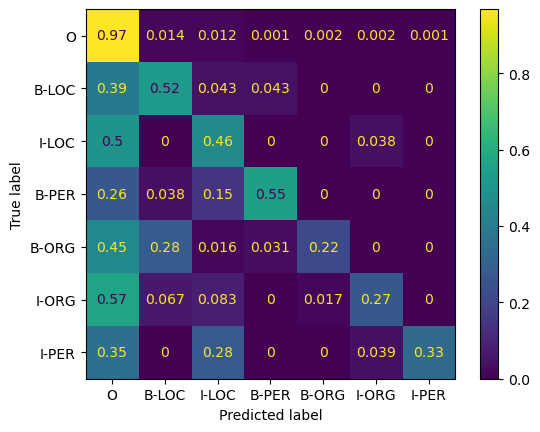

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

gold_tags = []
for sentence in new_number_data:
    gold_tags.append(sentence[1])

preds_tags = []
for predTag, goldTag in zip(predictionsTags, gold_tags):
    goldLen = len(goldTag)
    preds_tags.append(predTag[:goldLen])

gold_tags = [item for sublist in gold_tags for item in sublist]
preds_tags = [item for sublist in preds_tags for item in sublist]

gold_tags = gold_tags[:len(preds_tags)]

cm = confusion_matrix(gold_tags, preds_tags, labels=label_vocab.idx2word)
cm = cm[1:, 1:]

# Normalize it, since the labels might be imbalanced
normalized_matrix = cm.astype(float)
for i in range(len(normalized_matrix)):
    normalized_matrix[i] /= normalized_matrix[i].sum()
    for j in range(len(normalized_matrix[i])):
        normalized_matrix[i][j] = "{:.3f}".format(normalized_matrix[i][j])

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_matrix, display_labels=label_vocab.idx2word[1:])
disp.plot()

### BERT

##### Dev data

In [33]:
predictionTags = []

score = run_eval_bert(dev_sents_tokenized, dev_labels)

print('Accuracy for dev data: {:.4f}'.format(score))

print(dev_data[0][0])
print(len(predictionTags))
print(predictionTags[1])
print(dev_data[1][1])

# with open(os.path.join('data', 'bert_predictions_dev.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(dev_sents_tokenized, predictionTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")

# python3 span_f1.py data/bert_predictions_dev.iob2 data/en_ewt-ud-dev.iob2  <- run this in terminal to get span f1 score

Accuracy for dev data: 0.8983
['where', 'can', 'I', 'get', 'morcillas', 'in', 'tampa', 'bay', ',', 'I', 'will', 'like', 'the', 'argentinian', 'type', ',', 'but', 'I', 'will', 'to', 'try', 'anothers', 'please', '?']
2001
['O', 'O', 'O', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-

##### Create confusion matrix for BERT predictions on dev data

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

gold_tags = []
for sentence in dev_data:
    gold_tags.append(sentence[1])

preds_tags = []
for predTag, goldTag in zip(predictionTags, gold_tags):
    goldLen = len(goldTag)
    preds_tags.append(predTag[:goldLen])

gold_tags = [item for sublist in gold_tags for item in sublist]
preds_tags = [item for sublist in preds_tags for item in sublist]

cm = confusion_matrix(gold_tags, preds_tags, labels=label_vocab.idx2word)
cm = cm[1:, 1:]

# Normalize it, since the labels might be imbalanced
normalized_matrix = cm.astype(float)
for i in range(len(normalized_matrix)):
    normalized_matrix[i] /= normalized_matrix[i].sum()
    for j in range(len(normalized_matrix[i])):
        normalized_matrix[i][j] = "{:.3f}".format(normalized_matrix[i][j])

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_matrix, display_labels=label_vocab.idx2word[1:])
disp.plot()

NameError: name 'predictionTags' is not defined

In [76]:
from sklearn.metrics import classification_report

print(classification_report(gold_tags, preds_tags, target_names=label_vocab.idx2word[1:]))

              precision    recall  f1-score   support

           O       0.87      0.84      0.85       399
       B-LOC       0.67      0.63      0.65       224
       I-LOC       0.86      0.89      0.88       343
       B-PER       0.73      0.70      0.71       148
       B-ORG       0.75      0.62      0.68       186
       I-ORG       0.94      0.93      0.94       196
       I-PER       0.99      0.99      0.99     23653

    accuracy                           0.98     25149
   macro avg       0.83      0.80      0.81     25149
weighted avg       0.98      0.98      0.98     25149



##### Change names

In [27]:
predictionTags = []

names_sents_tokenized = []
for sentence in new_names_data:
    names_sents_tokenized.append(sentence[0])

score = run_eval_bert(names_sents_tokenized, dev_names_labels)

print('Accuracy for names data: {:.4f}'.format(score))

print(names_sents_tokenized[0])
print(predictionTags[0])

# with open(os.path.join('data', 'bert_predictions_names.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(names_sents_tokenized, predictionTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")
    
# python3 span_f1.py data/bert_predictions_names.iob2 data/gold_names.iob2 <- run this in terminal to get span f1 score

Accuracy for dev data: 0.7264
['Which', 'of', 'these', 'do', 'you', 'like', ':', 'McDonald', 's', ',', 'Burger', 'King', ',', 'Taco', 'Bell', ',', 'Wendy', 's', '?']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'B-ORG', 'I-ORG', 'O', 'B-ORG', 'I-ORG', 'O', 'B-ORG', 'I-ORG', 'O']


##### Change location

In [28]:
predictionTags = []

location_sents_tokanized = []
for sentence in new_location_data:
    location_sents_tokanized.append(sentence[0])

score = run_eval_bert(location_sents_tokanized, dev_location_labels)

print('Accuracy for location data: {:.4f}'.format(score))

print(location_sents_tokanized[0])
print(predictionTags[0])

# with open(os.path.join('data', 'bert_predictions_location.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(location_sents_tokanized, predictionTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")
    
# python3 span_f1.py data/bert_predictions_location.iob2 data/gold_location.iob2 <- run this in terminal to get span f1 score

Accuracy for location data: 0.7677
['There', 'are', 'way', 'more', 'stranger', 'names', 'in', 'the', 'U.S', 'for', 'areas', 'than', 'St.', 'Paul', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O']


##### Change numbers

In [29]:
predictionTags = []

numbers_sents_tokanized = []
for sentence in new_number_data:
    numbers_sents_tokanized.append(sentence[0])

score = run_eval_bert(numbers_sents_tokanized, dev_numbers_labels)

print('Accuracy for numbers data: {:.4f}'.format(score))

print(numbers_sents_tokanized[0])
print(predictionTags[0])

# with open(os.path.join('data', 'bert_predictions_numbers.iob2'), 'w') as f:
#     for sent_tokens, sent_preds in zip(numbers_sents_tokanized, predictionTags):
#         for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
#             f.write(f"{index}\t{token}\t{pred}\n")
#         f.write("\n")
    
# python3 span_f1.py data/bert_predictions_numbers.iob2 data/gold_numbers.iob2 <- run this in terminal to get span f1 score

Accuracy for numbers data: 0.8547
['2', 'cup', 'of', 'empanadas']
['O', 'O', 'O', 'O']
